# Imports

In [60]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

## Question 1


In [61]:

# Fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# Extract features and target
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [62]:
# Convert target to binary (0 for healthy, 1 for sick)
y['num'] = (y['num'] > 0).astype(int)


/var/folders/kp/ksnwmywj77sb5842vcdfqwg40000gn/T/ipykernel_35137/1908531385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['num'] = (y['num'] > 0).astype(int)


In [63]:
# Check for NaN values in features (X) and target (y)
print("NaN values in features:")
print(X.isna().sum())
print("\nNaN values in target:")
print(y.isna().sum())

# Remove rows with NaN values (if any)
# Method 1: Remove rows with any NaN values
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

# Verify no NaN values remain
print("\nRemaining NaN values in features:")
print(X_clean.isna().sum())


NaN values in features:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

NaN values in target:
num    0
dtype: int64

Remaining NaN values in features:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


In [64]:
# Prepare data for modeling
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [65]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_cat = encoder.fit_transform(X_clean[categorical_features])

# Get the correct feature names from the encoder
feature_names = []
for i, feature in enumerate(categorical_features):
    n_values = len(encoder.categories_[i]) - 1 
    for j in range(n_values):
        feature_names.append(f"{feature}_{j+1}")

# Create DataFrame with correct column names
X_cat = pd.DataFrame(X_cat, columns=feature_names)


In [66]:

# Combine with numerical features
X_cat = X_cat.reset_index(drop=True)
X_numerical = X_clean[numerical_features].reset_index(drop=True)

X_processed = pd.concat(
    [X_numerical, X_cat], 
    axis=1
)

print("X_processed shape:", X_processed.shape)


X_processed shape: (297, 20)


In [67]:
# First, ensure X and y have the same index
print("Shape of X:", X_processed.shape)
print("Shape of y:", y_clean.shape)


# Now split should work
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_clean['num'], test_size=0.2, random_state=42
)

Shape of X: (297, 20)
Shape of y: (297, 1)


In [68]:
# Fit random forest
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [69]:

# Best model evaluation
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))



Random Forest Results:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91        36
           1       0.90      0.79      0.84        24

    accuracy                           0.88        60
   macro avg       0.89      0.87      0.88        60
weighted avg       0.88      0.88      0.88        60



# Question 3
Let’s begin with an enrichment on the random forest interpretation.
- Get the variable importance of your features
- Recall the explanation you gave on them
- using the Treeexplainer function of the shap package, find the shapley values
- Visualise a couple of the explanations that are given with shap.forceplot. Can you explain them?
- Using the ”summary plot” with the ”plot type” equal to bar feature can you compare the importance that shapley gives to the importance that the native ”variable importance” has given you?
- Do you understand the plot if you remove the plot type?



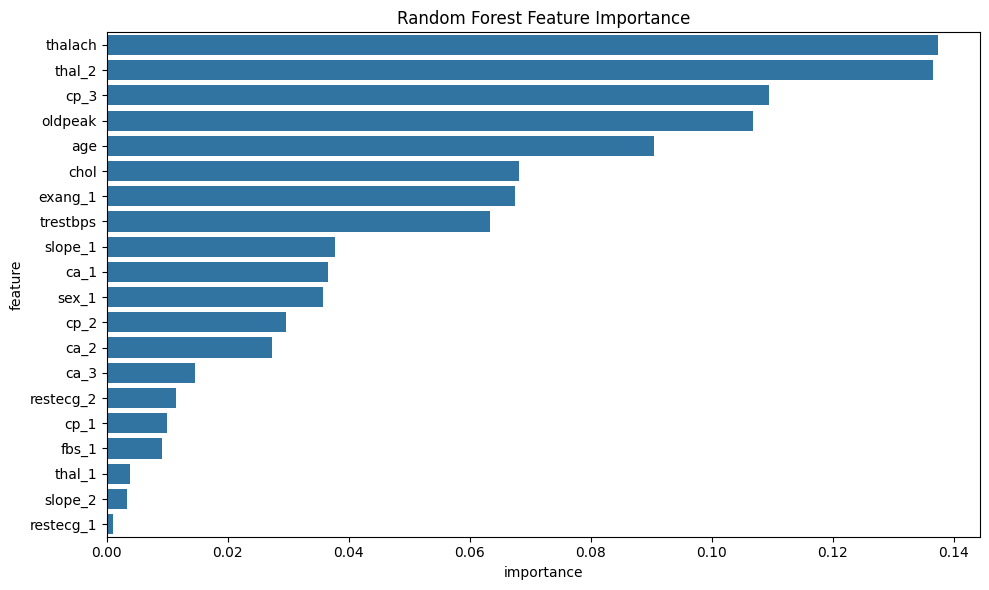

In [70]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


In [71]:

# Calculate SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer(X_test)
print(shap_values)


.values =
array([[[ 0.03064879, -0.03064879],
        [ 0.01421999, -0.01421999],
        [ 0.00715017, -0.00715017],
        ...,
        [ 0.00569061, -0.00569061],
        [ 0.00059634, -0.00059634],
        [ 0.07307563, -0.07307563]],

       [[ 0.03540984, -0.03540984],
        [ 0.00395991, -0.00395991],
        [ 0.02362613, -0.02362613],
        ...,
        [ 0.00327145, -0.00327145],
        [ 0.00064244, -0.00064244],
        [ 0.08450432, -0.08450432]],

       [[ 0.02913563, -0.02913563],
        [-0.00436781,  0.00436781],
        [-0.03456612,  0.03456612],
        ...,
        [ 0.00344483, -0.00344483],
        [ 0.00063762, -0.00063762],
        [ 0.0630567 , -0.0630567 ]],

       ...,

       [[-0.01641384,  0.01641384],
        [-0.01302028,  0.01302028],
        [-0.02407781,  0.02407781],
        ...,
        [ 0.00340514, -0.00340514],
        [ 0.00081633, -0.00081633],
        [ 0.06459906, -0.06459906]],

       [[-0.06237808,  0.06237808],
        [-0.00151

In [72]:
shap_values[0]

.values =
array([[ 0.03064879, -0.03064879],
       [ 0.01421999, -0.01421999],
       [ 0.00715017, -0.00715017],
       [-0.04319873,  0.04319873],
       [ 0.05839535, -0.05839535],
       [ 0.04436015, -0.04436015],
       [ 0.01249031, -0.01249031],
       [-0.00892626,  0.00892626],
       [ 0.06864027, -0.06864027],
       [-0.00153397,  0.00153397],
       [ 0.00030361, -0.00030361],
       [ 0.00605595, -0.00605595],
       [ 0.03264672, -0.03264672],
       [-0.02680803,  0.02680803],
       [ 0.00031199, -0.00031199],
       [ 0.01692833, -0.01692833],
       [ 0.00937197, -0.00937197],
       [ 0.00569061, -0.00569061],
       [ 0.00059634, -0.00059634],
       [ 0.07307563, -0.07307563]])

.base_values =
array([0.52742616, 0.47257384])

.data =
array([ 45., 112., 160., 138.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.])

In [73]:
explainer.expected_value

array([0.52742616, 0.47257384])

In [74]:
# Create force plot for first prediction
shap.initjs() 
shap.plots.force(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values.values[0, :,0], 
    features=X_test.iloc[0, :],
)

In [75]:
# Create force plot for first prediction
shap.plots.force(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values.values[:, :,0], 
    features=X_test.iloc[:, :],
)

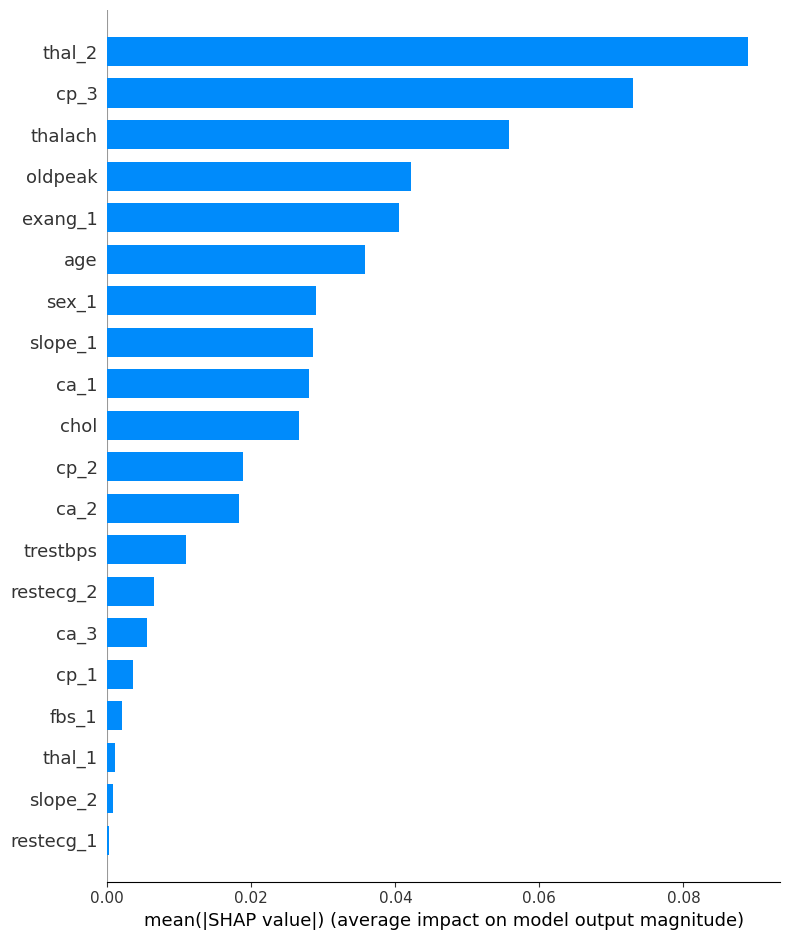

In [76]:

# Create summary plot with bar type
shap.summary_plot(shap_values.values[:, :, 0], X_test, plot_type="bar")


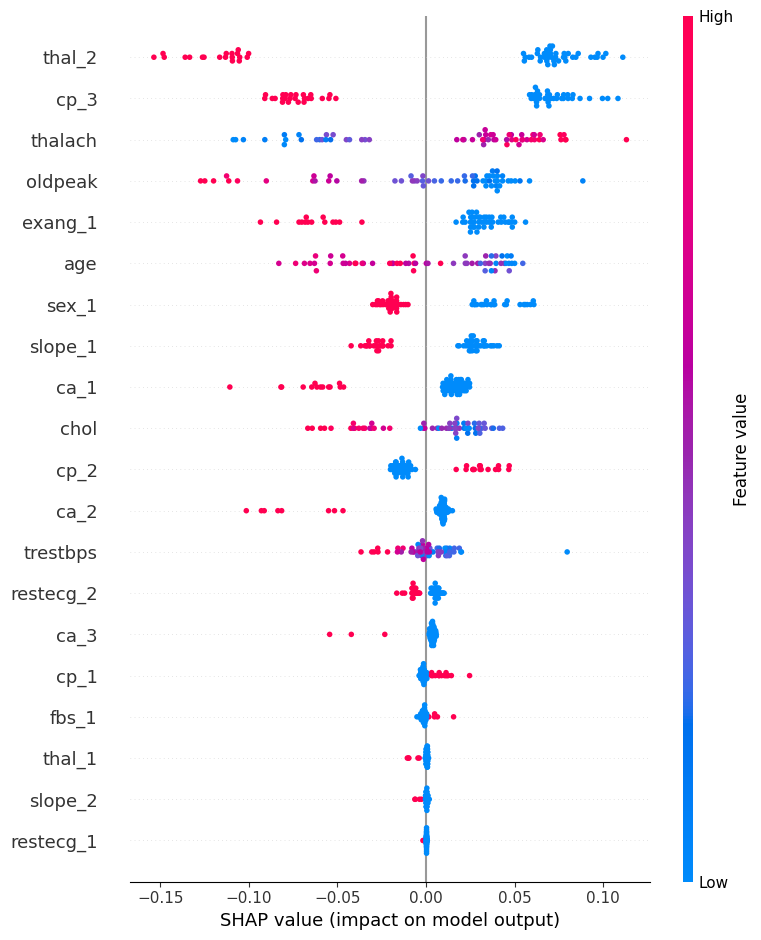

In [77]:

# Create summary plot without specifying plot type
shap.summary_plot(shap_values.values[:, :, 0], X_test)

# Question 4
Now lets work on a different model. Let’s train an Xgboost
- How does Xgboost work ? what is boosting? you can search the internet for these answers
- Install the Xgboost library if it’s not already installed
- Fit an Xgboost to your data and fine tune it
- Is it better than your Random Forest? why?


In [78]:
# Create XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)


In [79]:

# Parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [80]:

# Best model
best_xgb = grid_search.best_estimator_

# Predictions and evaluation
xgb_pred = best_xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost R^2: {xgb_r2}")


XGBoost MSE: 0.1188446668028764
XGBoost R^2: 0.5048139095306396


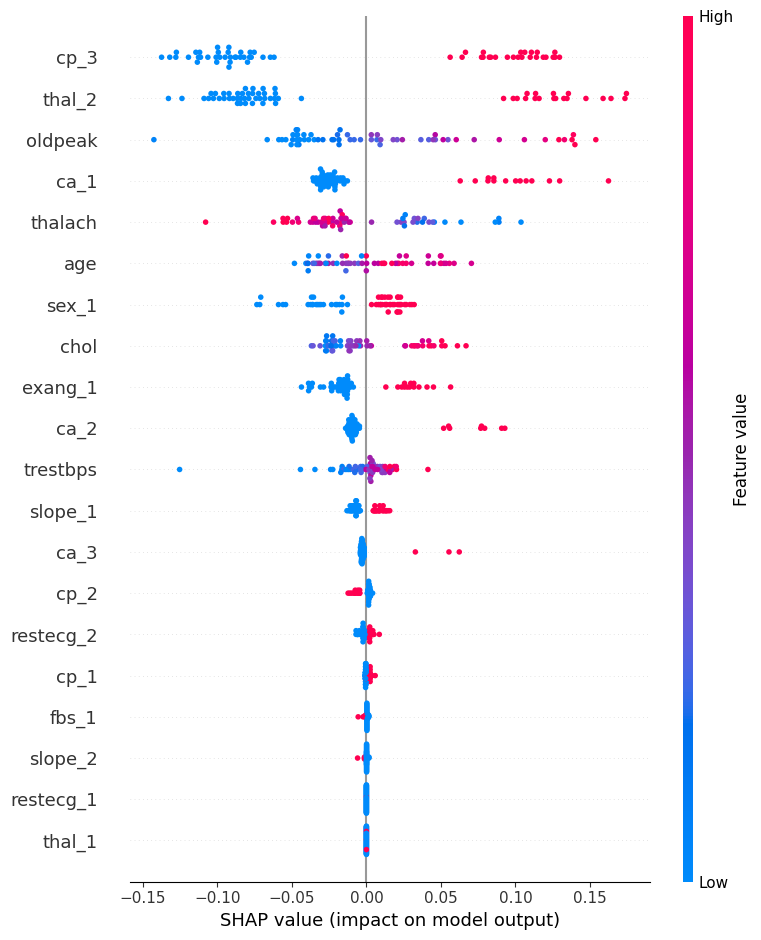

In [83]:

# Calculate SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb(X_test)

# Summary plot
shap.summary_plot(shap_values_xgb.values[:, :], X_test)


# Question 5
Let’s compare the feature importance of the Random Forest and the Xgboost
- Using shap’s tree explainer get the shapley values for this new model.
- Select the variables that are the most important and plot a dependency plot. Does the result confirm
your intuition?
- Compare the summary plot to the summary plot of the random forest. What are the changes?

In [86]:

# Dependency plots for top features
feature_importance = np.abs(shap_values_xgb.values[:, :]).mean(0)
top_features = X_test.columns[np.argsort(feature_importance)[-3:]]
for feature in top_features:
    shap.dependence_plot(feature, shap_values_xgb, X_test)



TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [ ]:


# PCA on SHAP values
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_xgb)
pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(shap_pca)

# Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(shap_pca[:, 0], shap_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering of SHAP Values')
plt.colorbar(scatter)
plt.show()